In [1]:
import torch
from neuralop.data.datasets.custom_darcy import CustomDarcyDataset, load_darcy_flow
import matplotlib.pyplot as plt
import sys
from neuralop.models import FNO, TFNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss, VinoDarcyLoss

In [2]:
resolution = 64

train_loader, test_loaders, data_processor = load_darcy_flow(
    root_dir="./data/",
    dataset_name='darcy_ZD_PWC',
    n_train=1000,
    n_tests=[50],
    batch_size=100,
    test_batch_sizes=[50],
    train_resolution=resolution,
    test_resolutions=[resolution],
    encode_input=True,
    encode_output=False,
)

Loading test db for resolution 64 with 50 samples 


In [3]:
class HardDirichletFNO(FNO):

    def forward(self, x, output_shape=None, **kwargs):
        x = super().forward(x, output_shape=output_shape, **kwargs)

        interior = torch.ones_like(x)
        interior[:, :,  0, :] = 0
        interior[:, :, -1, :] = 0
        interior[:, :, :,  0] = 0
        interior[:, :, :, -1] = 0

        return x * interior

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = HardDirichletFNO(
    n_modes=(16, 16),
    hidden_channels=64,
    in_channels=1,
    out_channels=1,
)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()

/home/jaeminseo/anaconda3/envs/PINN/lib/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")



Our model has 4769473 parameters.


In [5]:
n_epochs = 100
optimizer = AdamW(model.parameters(), lr=8e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = VinoDarcyLoss()
eval_losses={'h1': h1loss, 'l2': l2loss}

In [ ]:
import wandb
from datetime import datetime

wandb.init(
    project='Samsung_Project',
    name=f'VINO_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tjwoals217 (tjwoals217-Chung-Ang University) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [7]:
trainer = Trainer(model=model, 
                  n_epochs=n_epochs,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=True,
                  eval_interval=1,
                  use_distributed=False,
                  verbose=True)

trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 1000 samples
Testing on [50] samples         on resolutions [64].
Raw outputs of shape torch.Size([100, 1, 64, 64])
[0] time=0.97, avg_loss=5.4916, train_err=549.1584
Eval: 64_h1=7.6993, 64_l2=3.9315
[1] time=0.67, avg_loss=0.1388, train_err=13.8810
Eval: 64_h1=3.4484, 64_l2=0.9456
[2] time=0.67, avg_loss=0.0391, train_err=3.9085
Eval: 64_h1=1.2090, 64_l2=0.7043
[3] time=0.65, avg_loss=0.0094, train_err=0.9398
Eval: 64_h1=1.2150, 64_l2=1.1314
[4] time=0.67, avg_loss=0.0035, train_err=0.3505
Eval: 64_h1=1.1740, 64_l2=1.1048
[5] time=0.67, avg_loss=0.0010, train_err=0.0953
Eval: 64_h1=0.8982, 64_l2=0.8761
[6] time=0.67, avg_loss=-0.0002, train_err=-0.0181
Eval: 64_h1=0.8752, 64_l2=0.7618
[7] time=0.67, avg_loss=-0.0005, train_err=-0.0512
Eval: 64_h1=0.8452, 64_l2=0.8148
[8] time=0.67, avg_loss=-0.0007, train_err=-0.0743
Eval: 64_h1=0.8371, 64_l2=0.8254
[9] time=0.66, avg_loss=-0.0009, train_err=-0.0856
Eval: 64_h1=0.8025, 64_l2=0.7619
[10] time=0.68, avg_loss=-0.0010, train_e

{'train_err': -0.2658368408679962,
 'avg_loss': -0.002658368408679962,
 'avg_lasso_loss': None,
 'epoch_train_time': 0.6530706994235516,
 '64_h1': tensor(0.1931, device='cuda:0', dtype=torch.float64),
 '64_l2': tensor(0.0859, device='cuda:0', dtype=torch.float64)}

In [8]:
wandb.finish()

64_h1,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
64_l2,█▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,█████▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
time,▂▄▄▅▇▃▃█▄▆▂▂▃▄▄▅▅▅▆▃▅▃▃▄▆▁█▅▂▇▆▆▁▄█▅█▆▆▅
train_err,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
64_h1,0.19305
64_l2,0.08589
avg_loss,-0.00266
lr,0
time,0.65307


L2 error (0) : 0.05597736116880919
L2 error (1) : 0.055744176177026636
L2 error (2) : 0.09655509388083099


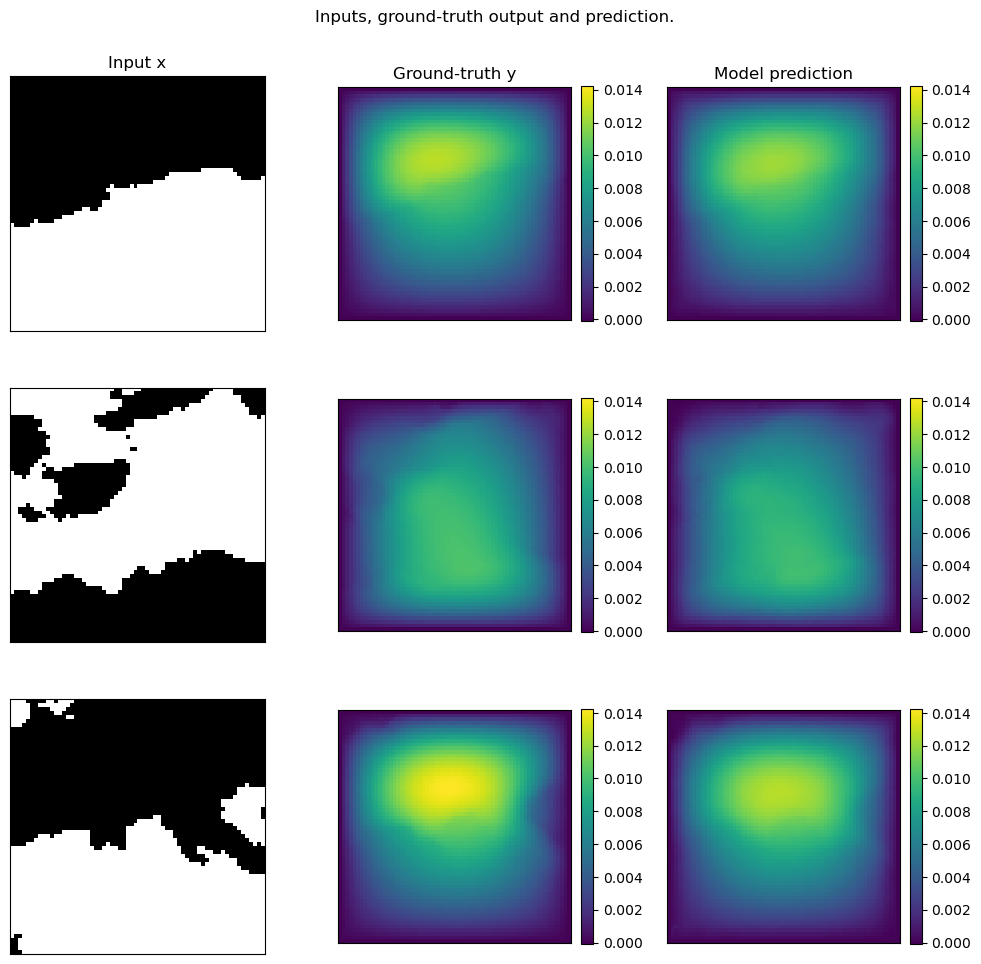

In [9]:
test_samples = test_loaders[64].dataset

# Step 1: Compute global min and max for consistent color scaling
vmin, vmax = float('inf'), float('-inf')
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)

    x = data['x']
    y = data['y']
    out = model(x)

    # y = data_processor.out_normalizer.inverse_transform(y).squeeze().detach()
    # out = data_processor.out_normalizer.inverse_transform(out).squeeze().detach()

    vmin = min(vmin, y.min().item(), out.min().item())
    vmax = max(vmax, y.max().item(), out.max().item())

# Step 2: Plot with consistent vmin/vmax and add colorbars
fig = plt.figure(figsize=(10, 10))

for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)

    x = data['x'].to(device)
    y = data['y'].to(device)
    out = model(x).squeeze().detach()

    # y = data_processor.out_normalizer.inverse_transform(y)
    # out = data_processor.out_normalizer.inverse_transform(out)

    # Input x
    ax = fig.add_subplot(3, 3, index * 3 + 1)
    im = ax.imshow(x[0][0].cpu(), cmap='gray')
    if index == 0: 
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])
    
    # Ground-truth y
    ax = fig.add_subplot(3, 3, index * 3 + 2)
    im = ax.imshow(y.squeeze().cpu(), vmin=vmin, vmax=vmax)
    if index == 0: 
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Model prediction
    ax = fig.add_subplot(3, 3, index * 3 + 3)
    im = ax.imshow(out.squeeze().cpu(), vmin=vmin, vmax=vmax)
    if index == 0: 
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    print(f'L2 error ({index}) : {torch.norm(out - y) / torch.norm(y)}')

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
plt.show()